In [1]:
import pandas as pd
import matplotlib

%matplotlib inline

In [2]:
confirmations = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv", index_col='Country/Region')
deaths = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv", index_col='Country/Region')

In [3]:
def all_larger(args, threshold):
    return all(x > threshold for x in args)

In [4]:
def get_breakout_date_for(country, continuous_increases):
    increases = continuous_increases[country]
    df = increases[increases == 1.0]
    if len(df) > 0:
        return df.index[0]
    else:
        return '3/1/20'

In [5]:
def get_data_after_breakout_for(country, countries, continuous_increases):
    breakout_date = get_breakout_date_for(country, continuous_increases)
    df = countries[[country]][breakout_date:].reset_index()
    df.index.names = ['Days']
    df.columns.names = ['Country']
    
    return df[[country]]

In [6]:
def process(df, title, window_size):
    countries = df.drop(['Province/State', 'Lat', 'Long'], axis=1).groupby('Country/Region').sum().T
    country_names = list(countries.columns)
    continuous_increases = countries.pct_change(axis=0). \
        rolling(window_size). \
        apply(all_larger, kwargs={'threshold':0.05}) \
        .shift(-window_size)
    dfs = [get_data_after_breakout_for(c, countries, continuous_increases) for c in country_names]
    breakout_data = dfs[0].join(dfs[1:], how='outer')
    breakout_data.index.names = ['Days']
    breakout_data.reset_index(level=0, inplace=True)
    
    bd = breakout_data.loc[:, breakout_data.columns != 'Days']
    daily_increases = bd - bd.shift(1)
    daily_increases['Days'] = breakout_data['Days']
    
    return countries, breakout_data, daily_increases

In [7]:
%matplotlib inline

In [8]:
from plotnine import *

In [9]:
countries_confirmed, breakout_confirmed, daily_increases_confirmed = \
    process(confirmations, "Confirmed Infections", window_size=5)
countries_deaths, breakout_deaths, daily_increases_deaths = \
    process(deaths, "Confirmed Infections", window_size=1)

In [10]:
def plot_country_numbers(countries, df, title, log_scale=False):
    df = df[['Days'] + countries].melt(id_vars='Days').dropna()
    return  ggplot(df, aes(x='Days', y='value', colour='Country')) + \
                theme_xkcd() + ylab('Count') + ggtitle(title) + \
                xlab("Days since breakout")

In [11]:
countries_to_focus = [
    'United Kingdom', 
    'Italy', 
    'Spain', 
    'Germany', 
    'France', 
    'US', 
    'Korea, South', 
    'Vietnam', 
    'China',
]

countries_without_china = [c for c in countries_to_focus if c != 'China']

/home/ashic/.conda/envs/corona/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/ashic/.conda/envs/corona/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../charts/infections-since-breakout.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


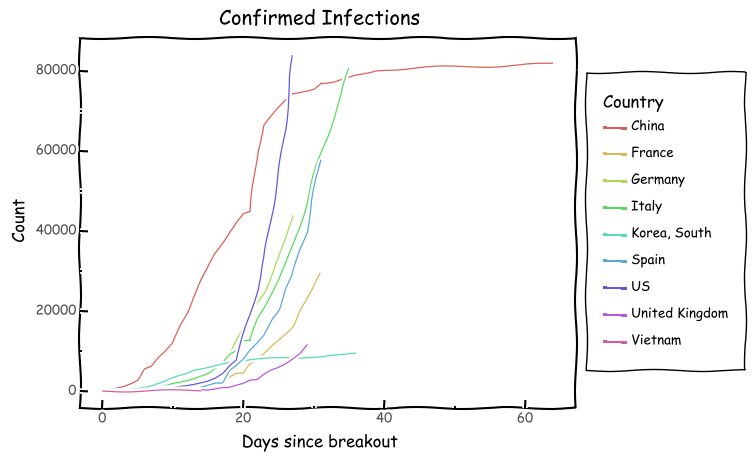

<ggplot: (8765936264357)>

In [12]:
p = plot_country_numbers(countries_to_focus, breakout_confirmed, "Confirmed Infections") + geom_line()
p.save('../charts/infections-since-breakout.png', format="png")
p

/home/ashic/.conda/envs/corona/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/ashic/.conda/envs/corona/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../charts/infections-since-breakout-no-china.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


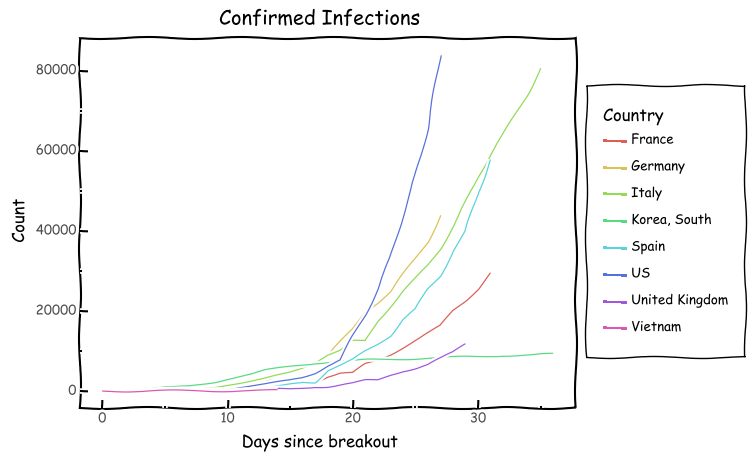

<ggplot: (8765933495141)>

In [13]:
p = plot_country_numbers(countries_without_china, breakout_confirmed, "Confirmed Infections") + geom_line()
p.save('../charts/infections-since-breakout-no-china.png', format="png")
p

/home/ashic/.conda/envs/corona/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/ashic/.conda/envs/corona/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../charts/infections-since-breakout-log.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


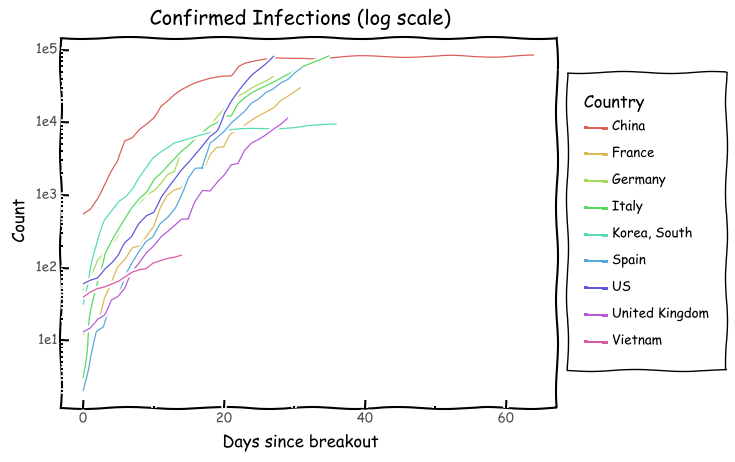

<ggplot: (8765936296033)>

In [14]:
p = plot_country_numbers(countries_to_focus, breakout_confirmed, "Confirmed Infections (log scale)") + geom_line() + \
    scale_y_log10()
p.save('../charts/infections-since-breakout-log.png', format="png")
p

/home/ashic/.conda/envs/corona/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/ashic/.conda/envs/corona/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../charts/infections-since-breakout-log-no-china.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


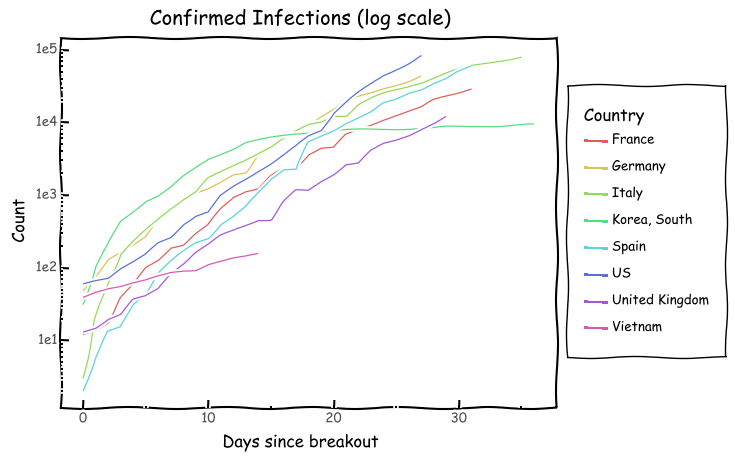

<ggplot: (8765936247797)>

In [15]:
p = plot_country_numbers(countries_without_china, breakout_confirmed, "Confirmed Infections (log scale)") + geom_line() + \
    scale_y_log10()
p.save('../charts/infections-since-breakout-log-no-china.png', format="png")
p

/home/ashic/.conda/envs/corona/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/ashic/.conda/envs/corona/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../charts/deaths-since-breakout.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


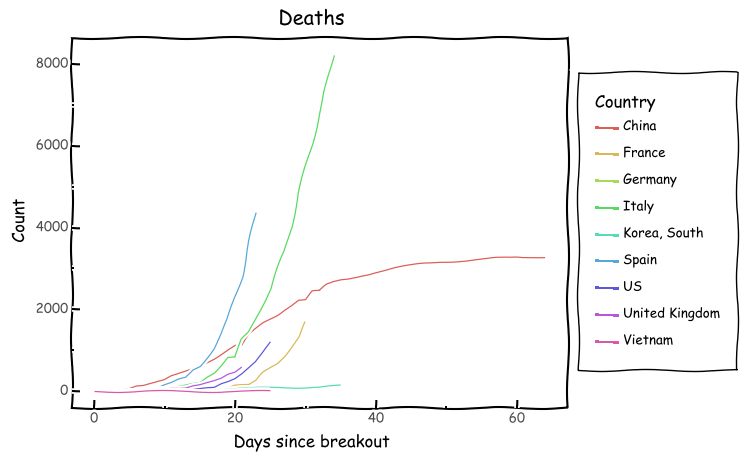

<ggplot: (8765933658693)>

In [16]:
p = plot_country_numbers(countries_to_focus, breakout_deaths, "Deaths") + geom_line() 
p.save('../charts/deaths-since-breakout.png', format="png")
p

/home/ashic/.conda/envs/corona/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/ashic/.conda/envs/corona/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../charts/deaths-since-breakout-no-china.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


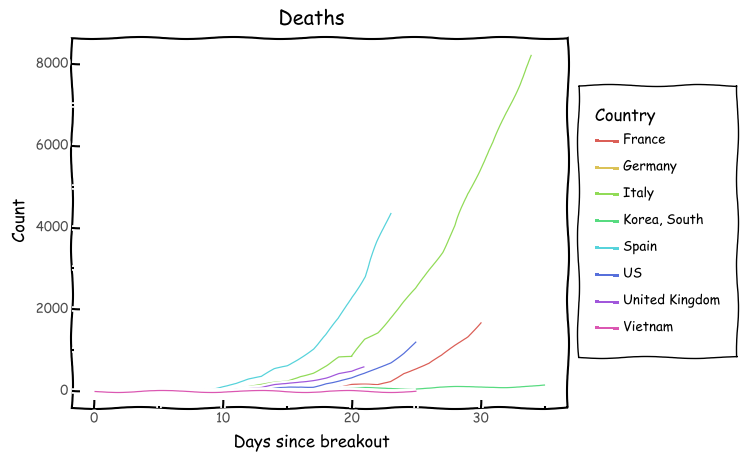

<ggplot: (8765927494785)>

In [17]:
p = plot_country_numbers(countries_without_china, breakout_deaths, "Deaths") + geom_line() 
p.save('../charts/deaths-since-breakout-no-china.png', format="png")
p

/home/ashic/.conda/envs/corona/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/ashic/.conda/envs/corona/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../charts/deaths-since-breakout-log.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
/home/ashic/.conda/envs/corona/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ashic/.conda/envs/corona/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


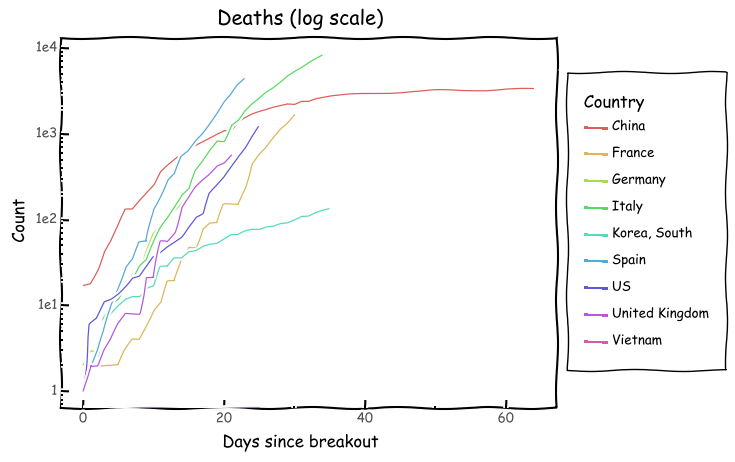

<ggplot: (8765927242025)>

In [18]:
p = plot_country_numbers(countries_to_focus, breakout_deaths, "Deaths (log scale)") + geom_line() + scale_y_log10()
p.save('../charts/deaths-since-breakout-log.png', format="png")
p

/home/ashic/.conda/envs/corona/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/ashic/.conda/envs/corona/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../charts/deaths-since-breakout-log-no-china.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
/home/ashic/.conda/envs/corona/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ashic/.conda/envs/corona/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


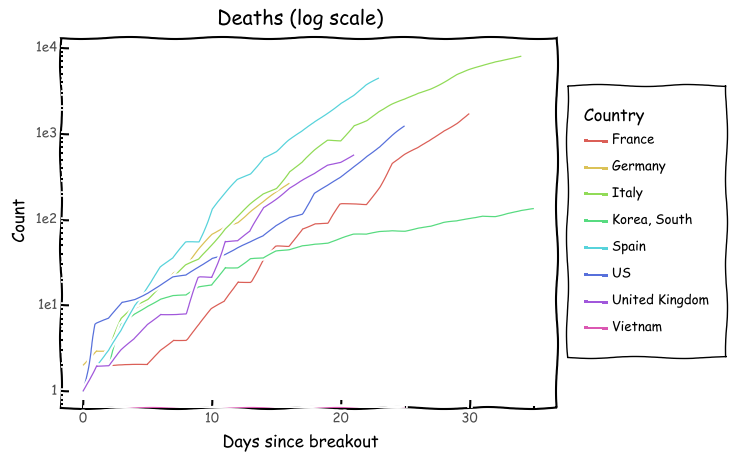

<ggplot: (8765927567037)>

In [19]:
p = plot_country_numbers(countries_without_china, breakout_deaths, "Deaths (log scale)") \
    + geom_line() + scale_y_log10()
p.save('../charts/deaths-since-breakout-log-no-china.png', format="png")
p

/home/ashic/.conda/envs/corona/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/ashic/.conda/envs/corona/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../charts/infection-increases.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
/home/ashic/.conda/envs/corona/lib/python3.7/site-packages/plotnine/stats/smoothers.py:168: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  "for lowess smoothings.", PlotnineWarning)
/home/ashic/.conda/envs/corona/lib/python3.7/site-packages/plotnine/stats/smoothers.py:168: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  "for lowess smoothings.", PlotnineWarning)


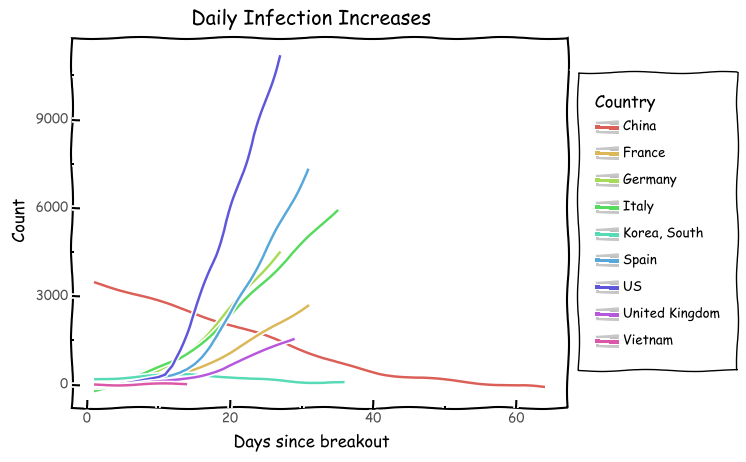

<ggplot: (8765927321897)>

In [20]:
p = plot_country_numbers(countries_to_focus, daily_increases_confirmed, "Daily Infection Increases") \
    + stat_smooth()
p.save('../charts/infection-increases.png', format="png")
p

/home/ashic/.conda/envs/corona/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/ashic/.conda/envs/corona/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../charts/death-increases.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
/home/ashic/.conda/envs/corona/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ashic/.conda/envs/corona/lib/python3.7/site-packages/plotnine/stats/smoothers.py:168: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  "for lowess smoothings.", PlotnineWarning)
/home/ashic/.conda/envs/corona/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ashic/.conda

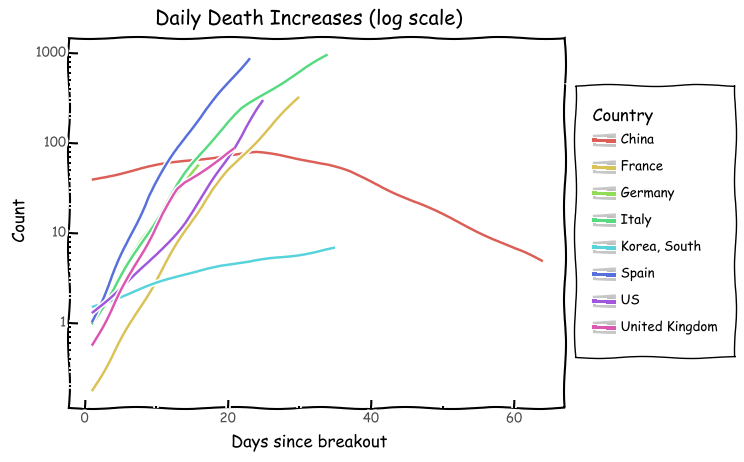

<ggplot: (8765927391421)>

In [21]:
p = plot_country_numbers(countries_to_focus, daily_increases_deaths, "Daily Death Increases (log scale)") \
    + stat_smooth() \
    + scale_y_log10()
p.save('../charts/death-increases.png', format="png")
p

In [22]:
def plot_bar(df, countries, title):
    df = df[countries].tail(1).T
    df.columns = ['Count']
    df.index.names = ['Country']
    df = df.reset_index()
    
    return  ggplot(df, aes(x='Country', y='Count', colour='Country')) + \
                theme_xkcd() + ylab('Count') + ggtitle(title) + \
                xlab("Countries") + geom_bar(stat='identity', fill='White') +\
                theme(axis_text_x = element_text(angle=45)) + theme(legend_position = "none")

/home/ashic/.conda/envs/corona/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/ashic/.conda/envs/corona/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../charts/confirmed-cases.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


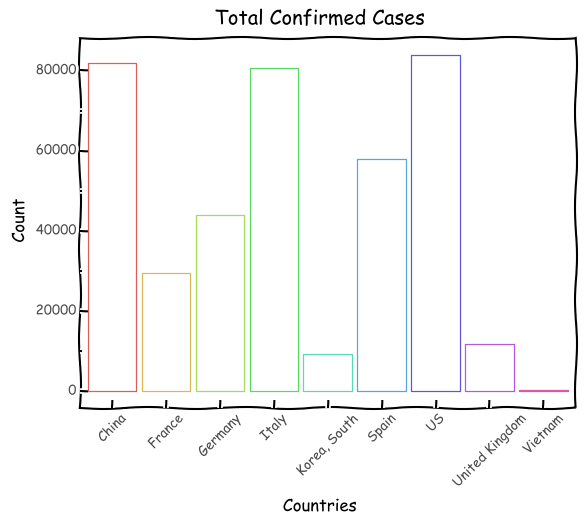

<ggplot: (8765933422373)>

In [23]:
p = plot_bar(countries_confirmed, countries_to_focus, "Total Confirmed Cases")
p.save('../charts/confirmed-cases.png', format="png")
p

/home/ashic/.conda/envs/corona/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/ashic/.conda/envs/corona/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../charts/confirmed-cases-no-china.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


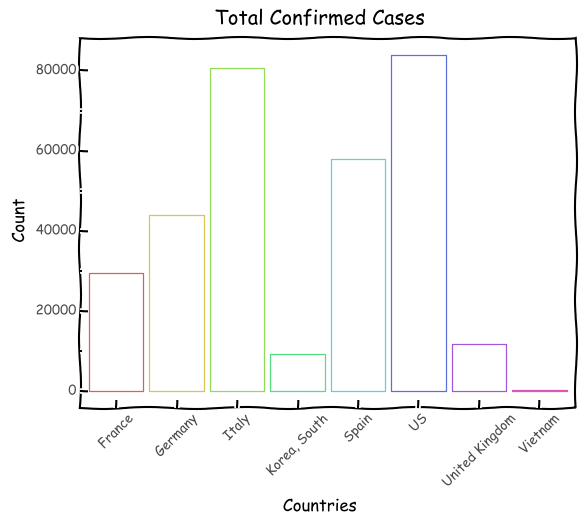

<ggplot: (8765957335637)>

In [24]:
p = plot_bar(countries_confirmed, countries_without_china, "Total Confirmed Cases")
p.save('../charts/confirmed-cases-no-china.png', format="png")
p

/home/ashic/.conda/envs/corona/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/ashic/.conda/envs/corona/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../charts/confirmed-cases-log.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


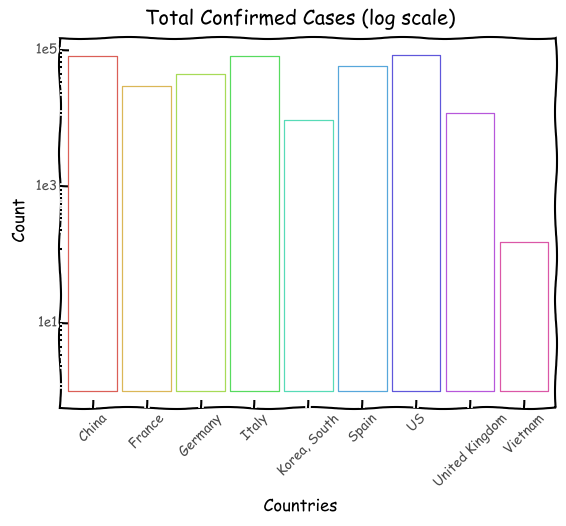

<ggplot: (8765927352281)>

In [25]:
p = plot_bar(countries_confirmed, countries_to_focus, "Total Confirmed Cases (log scale)") + \
        scale_y_log10()
p.save('../charts/confirmed-cases-log.png', format="png")
p

/home/ashic/.conda/envs/corona/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/ashic/.conda/envs/corona/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../charts/deaths.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


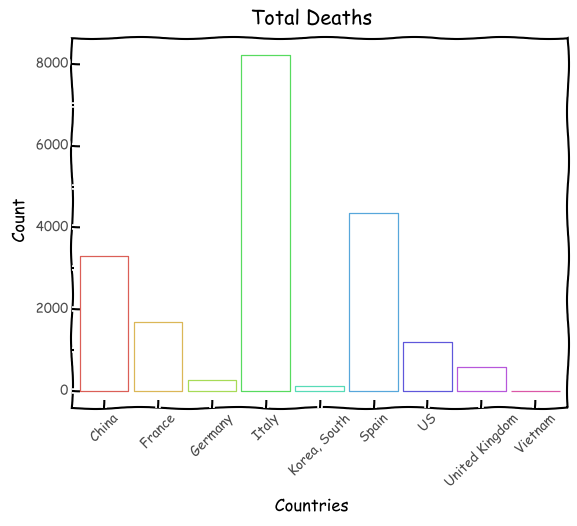

<ggplot: (8765927575477)>

In [26]:
p = plot_bar(countries_deaths, countries_to_focus, "Total Deaths")
p.save('../charts/deaths.png', format="png")
p

/home/ashic/.conda/envs/corona/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/ashic/.conda/envs/corona/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../charts/deaths-no-china.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


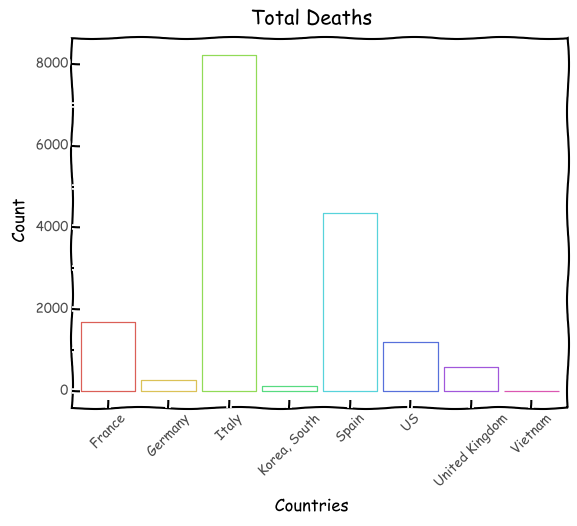

<ggplot: (8765933503557)>

In [27]:
p = plot_bar(countries_deaths, countries_without_china, "Total Deaths")
p.save('../charts/deaths-no-china.png', format="png")
p

/home/ashic/.conda/envs/corona/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/ashic/.conda/envs/corona/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../charts/deaths-log.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
/home/ashic/.conda/envs/corona/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ashic/.conda/envs/corona/lib/python3.7/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_bar : Removed 1 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
/home/ashic/.conda/envs/corona/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ashic/.conda/envs/corona/lib/python3.7/si

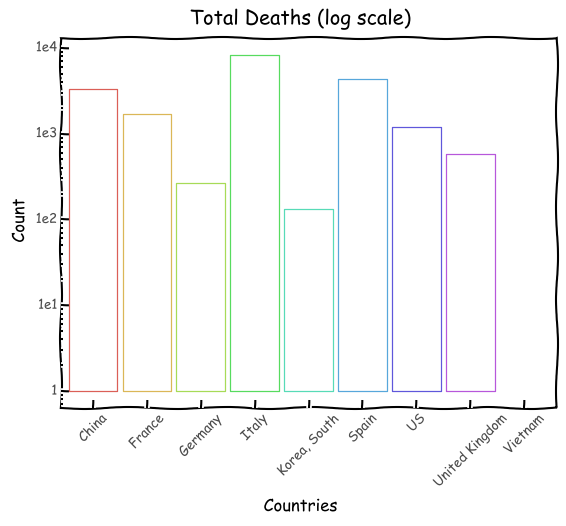

<ggplot: (8765933582065)>

In [28]:
p = plot_bar(countries_deaths, countries_to_focus, "Total Deaths (log scale)") + scale_y_log10()
p.save('../charts/deaths-log.png', format="png")
p

In [29]:
countries_confirmed[countries_to_focus].tail(5)

Country/Region,United Kingdom,Italy,Spain,Germany,France,US,"Korea, South",Vietnam,China
3/22/20,5745,59138,28768,24873,16243,33276,8961,113,81435
3/23/20,6726,63927,35136,29056,20123,43847,8961,123,81498
3/24/20,8164,69176,39885,32986,22622,53740,9037,134,81591
3/25/20,9640,74386,49515,37323,25600,65778,9137,141,81661
3/26/20,11812,80589,57786,43938,29551,83836,9241,153,81782


In [30]:
countries_deaths[countries_to_focus].tail(5)

Country/Region,United Kingdom,Italy,Spain,Germany,France,US,"Korea, South",Vietnam,China
3/22/20,282,5476,1772,94,676,417,111,0,3274
3/23/20,336,6077,2311,123,862,557,111,0,3274
3/24/20,423,6820,2808,157,1102,706,120,0,3281
3/25/20,466,7503,3647,206,1333,942,126,0,3285
3/26/20,580,8215,4365,267,1698,1209,131,0,3291


In [31]:
daily_increases_deaths[countries_to_focus].head(25)

Country,United Kingdom,Italy,Spain,Germany,France,US,"Korea, South",Vietnam,China
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,1.0,1.0,1.0,1.0,5.0,1.0,0.0,1.0
2,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,8.0
3,1.0,4.0,2.0,4.0,0.0,4.0,4.0,0.0,16.0
4,1.0,3.0,5.0,2.0,0.0,1.0,2.0,0.0,14.0
5,2.0,2.0,7.0,2.0,0.0,2.0,2.0,0.0,26.0
6,2.0,5.0,11.0,6.0,1.0,3.0,2.0,0.0,49.0
7,0.0,4.0,7.0,7.0,1.0,4.0,1.0,0.0,2.0
8,0.0,8.0,19.0,4.0,0.0,1.0,0.0,0.0,38.0
9,13.0,5.0,1.0,16.0,2.0,6.0,3.0,0.0,42.0
